In [1]:
## 원핫 없이

import pandas as pd

# Load the dataset
file_path = 'Korea_Income_and_Welfare.csv'
data = pd.read_csv(file_path)

# Define mappings and reverse mappings for various categories
region_map = {1: "Seoul", 2: "Kyeong-gi", 3: "Kyoung-nam", 4: "Kyoung-buk", 5: "Chung-nam", 6: "Gang-won & Chung-buk", 7: "Jeolla & Jeju"}
gender_map = {1: "Male", 2: "Female"}
education_level_map = {1: "No education (under 7 yrs-old)", 2: "No education (7 & over 7 yrs-old)", 3: "Elementary", 4: "Middle school", 5: "High school", 6: "College", 7: "University degree", 8: "MA", 9: "Doctoral degree"}
religion_map = {1: "Have religion", 2: "Do not have"}

# Reverse maps
region_reverse_map = {v: k for k, v in region_map.items()}
gender_reverse_map = {v: k for k, v in gender_map.items()}
education_level_reverse_map = {v: k for k, v in education_level_map.items()}
religion_reverse_map = {v: k for k, v in religion_map.items()}

# Apply the reverse mappings
data['region'] = data['region'].map(region_reverse_map)
data['gender'] = data['gender'].map(gender_reverse_map)
data['education_level'] = data['education_level'].map(education_level_reverse_map)
data['religion'] = data['religion'].map(religion_reverse_map)

# Calculate age
data['age'] = data['year'] - data['year_born']

# Remove unrealistic age values (less than 0 or greater than 120)
data = data[(data['age'] >= 0) & (data['age'] <= 120)]

# Drop the 'year_born' column
data.drop(columns=['year_born'], inplace=True)

# Drop unnecessary columns
data.drop(columns=['occupation', 'reason_none_worker'], inplace=True)

# Handle negative income values
data['income'] = data['income'].apply(lambda x: x if x >= 0 else pd.NA)

# Drop rows with any NaN values in essential columns
data.dropna(subset=['region', 'income', 'family_member', 'gender', 'education_level', 'marriage', 'religion', 'age'], inplace=True)

# Region movement calculation
data['region_movement'] = None
def check_region_movement(df):
    df.sort_values('year', inplace=True)
    df['previous_region'] = df['region'].shift(1)
    # Apply movement checking, but set the first entry's region_movement to None
    df['region_movement'] = df.apply(lambda row: None if pd.isna(row['previous_region']) else (row['region'] if row['region'] != row['previous_region'] else None), axis=1)
    return df.drop(columns=['previous_region'])


def check_region_movement(df):
    df.sort_values('year', inplace=True)
    df['previous_region'] = df['region'].shift(1)
    # 첫 번째 항목에 대해서는 region_movement를 None으로 설정
    df['region_movement'] = df.apply(lambda row: None if pd.isna(row['previous_region']) else (row['region'] if row['region'] != row['previous_region'] else None), axis=1)
    # 필요없는 'previous_region' 열을 제거
    return df.drop(columns=['previous_region'])


# Apply the function and reset index
data = data.groupby('id').apply(check_region_movement).reset_index(drop=True)

# Save the modified data to a new CSV file
output_file_path = 'Korea_Income_and_Welfare_Filter.csv'
data.to_csv(output_file_path, index=False)


/var/folders/6f/wv_c62016wx7vx7_xdts9m740000gn/T/ipykernel_10176/323252324.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = data.groupby('id').apply(check_region_movement).reset_index(drop=True)


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 로드
file_path = 'Korea_Income_and_Welfare.csv'
data = pd.read_csv(file_path)

# 나이 계산 및 비현실적 나이 값 제거
data['age'] = data['year'] - data['year_born']
data = data[(data['age'] >= 0) & (data['age'] <= 120)]

# 음수 수입 값 처리
data['income'] = data['income'].apply(lambda x: x if x >= 0 else None)

# 필수 컬럼에서 NaN 값 제거
data.dropna(subset=['region', 'income', 'family_member', 'gender', 'education_level', 'marriage', 'religion', 'age', 'company_size'], inplace=True)

# 지역 이동 확인 함수 정의 및 적용 (원-핫 인코딩 전에 적용)
def check_region_movement(df):
    df.sort_values('year', inplace=True)
    df['previous_region'] = df['region'].shift(1)
    # 이전 지역이 NaN인 경우 현재 지역으로 설정
    df['previous_region'] = df['previous_region'].fillna(df['region'])
    df['region_movement'] = df.apply(lambda row: row['region'] if row['region'] != row['previous_region'] else None, axis=1)
    return df

data = data.groupby('id').apply(check_region_movement).reset_index(drop=True)

# 필요없는 컬럼 제거
data.drop(columns=['year_born'], inplace=True)

# OneHotEncoder 설정
encoder = OneHotEncoder()
categorical_columns = ['region', 'gender', 'marriage', 'religion']
data_encoded = encoder.fit_transform(data[categorical_columns])
column_names = encoder.get_feature_names_out(categorical_columns)

# 원-핫 인코딩 데이터를 DataFrame으로 변환
data_encoded = pd.DataFrame(data_encoded.toarray(), columns=column_names)

# 인코딩되지 않은 데이터와 병합
data = pd.concat([data.reset_index(drop=True), data_encoded.reset_index(drop=True)], axis=1)
data.drop(columns=categorical_columns, inplace=True)  # 원본 범주형 컬럼 삭제

# 수정된 데이터를 CSV 파일로 저장
output_file_path = 'Processed_Korea_Income_and_Welfare.csv'
data.to_csv(output_file_path, index=False)

print("데이터 처리가 완료되었으며, 다음 파일에 저장되었습니다:", output_file_path)


In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 로드
file_path = 'Korea_Income_and_Welfare.csv'
data = pd.read_csv(file_path)

# 나이 계산 및 비현실적 나이 값 제거
data['age'] = data['year'] - data['year_born']
data = data[(data['age'] >= 0) & (data['age'] <= 120)]

# 음수 수입 값 처리
data['income'] = data['income'].apply(lambda x: x if x >= 0 else None)

# 필수 컬럼에서 NaN 값 제거
data.dropna(subset=['region', 'income', 'family_member', 'gender', 'education_level', 'marriage', 'religion', 'age', 'company_size'], inplace=True)

# 지역 이동 확인 함수 정의 및 적용 (원-핫 인코딩 전에 적용)
def check_region_movement(df):
    df.sort_values('year', inplace=True)
    df['previous_region'] = df['region'].shift(1)
    # 이전 지역이 NaN인 경우 현재 지역으로 설정
    df['previous_region'] = df['previous_region'].fillna(df['region'])
    df['region_movement'] = df.apply(lambda row: None if pd.isna(row['previous_region']) else (row['region'] if row['region'] != row['previous_region'] else None), axis=1)
    return df

data = data.groupby('id').apply(check_region_movement).reset_index(drop=True)

# 필요없는 컬럼 제거
data.drop(columns=['year_born','wave','reason_none_worker','occupation'], inplace=True)

# OneHotEncoder 설정
encoder = OneHotEncoder()
categorical_columns = ['region', 'gender', 'marriage', 'religion']
data_encoded = encoder.fit_transform(data[categorical_columns])
column_names = encoder.get_feature_names_out(categorical_columns)

# 원-핫 인코딩 데이터를 DataFrame으로 변환
data_encoded = pd.DataFrame(data_encoded.toarray(), columns=column_names)

# 인코딩되지 않은 데이터와 병합
data = pd.concat([data.reset_index(drop=True), data_encoded.reset_index(drop=True)], axis=1)
data.drop(columns=categorical_columns, inplace=True)  # 원본 범주형 컬럼 삭제

# 수정된 데이터를 CSV 파일로 저장
output_file_path = 'Processed_Korea_Income_and_Welfare.csv'
data.to_csv(output_file_path, index=False)

print("데이터 처리가 완료되었으며, 다음 파일에 저장되었습니다:", output_file_path)

데이터 처리가 완료되었으며, 다음 파일에 저장되었습니다: Processed_Korea_Income_and_Welfare.csv


In [3]:
## 민맥스 이후 랜덤 포레스트 

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 데이터셋 로드
file_path = 'Processed_Korea_Income_and_Welfare.csv'
data = pd.read_csv(file_path)

# 수치형 데이터 정규화
scaler = MinMaxScaler()
numeric_columns = ['income', 'family_member', 'age']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 타겟 변수 설정
data['region_movement'] = data['region_movement'].apply(lambda x: 1 if pd.notna(x) else 0)
X = data.drop(columns=['id', 'year', 'education_level', 'company_size', 'previous_region', 'region_movement'])
y = data['region_movement']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.9849900113384806
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18267
           1       0.04      0.00      0.01       254

    accuracy                           0.98     18521
   macro avg       0.51      0.50      0.50     18521
weighted avg       0.97      0.98      0.98     18521



In [ ]:
#시각화

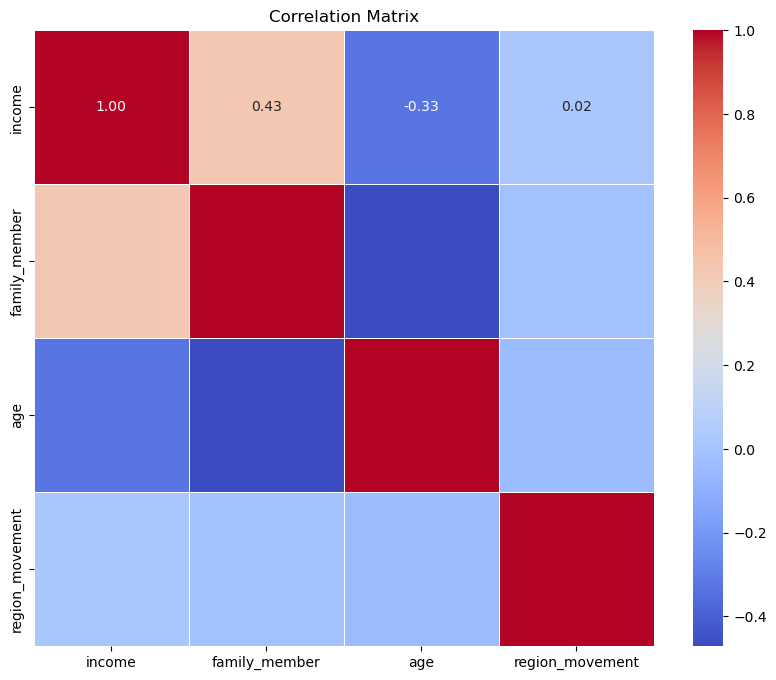

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'No education (7 & over 7 yrs-old)'

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import numpy as np

# 데이터셋 로드
file_path = 'Processed_Korea_Income_and_Welfare.csv'
data = pd.read_csv(file_path)

# 수치형 데이터 정규화
scaler = MinMaxScaler()
numeric_columns = ['income', 'family_member', 'age']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 타겟 변수 설정
data['region_movement'] = data['region_movement'].apply(lambda x: 1 if pd.notna(x) else 0)

# 상관계수 계산 (수치형 데이터만)
numeric_data = data[numeric_columns + ['region_movement']]
correlation_matrix = numeric_data.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# NaN 값 처리 (평균으로 채움)
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# 데이터 분할
random_state = 42
X = data.drop(columns=['id', 'year', 'education_level', 'company_size', 'previous_region', 'region_movement'])
y = data['region_movement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 모델 학습 (랜덤 포레스트 예시)
model = RandomForestClassifier(n_estimators=100, random_state=random_state, class_weight='balanced')
model.fit(X_train, y_train)

# 이사 확률 예측 함수
def predict_movement(sample):
    prob = model.predict_proba(sample)[0][1]  # 이사할 확률
    return prob

# 이사할 것으로 예측된 샘플에 대한 예상 지역 예측 준비
# 원본 데이터셋에서 'region_movement'가 1인 샘플만 사용하여 예상 지역 예측 모델 학습
movement_data = data[data['region_movement'] == 1]
X_movement = movement_data.drop(columns=['id', 'year', 'education_level', 'company_size', 'previous_region', 'region_movement'])
y_movement = movement_data[[col for col in data.columns if 'region_' in col]]

# 예상 지역 예측 모델 학습 (예: 랜덤 포레스트)
region_model = RandomForestClassifier(n_estimators=100, random_state=random_state)
region_model.fit(X_movement, y_movement)

# 이사 확률과 예상 지역 예측 함수
def predict_movement_and_region(sample):
    prob = predict_movement(sample)
    if prob > 0.5:  # 예: 이사할 확률이 50% 이상인 경우
        region_probs = region_model.predict_proba(sample)
        region = y_movement.columns[np.argmax(region_probs)]
        return prob, region
    else:
        return prob, None

# 이사할 확률이 높을 법한 예시 샘플 생성
example_sample = pd.DataFrame({
    'income': [0.9],  # 높은 수입
    'family_member': [0.8],  # 다수의 가족 구성원
    'age': [0.85],  # 고령
    'region_Seoul': [1], 'region_Kyeong-gi': [0], 'region_Gang-won & Chung-buk': [0], 
    'region_Kyoung-buk': [0], 'region_Kyoung-nam': [0], 'region_Jeolla & Jeju': [0],
    'gender_Female': [1], 'gender_Male': [0], 'marriage_0': [0], 'marriage_1': [0], 'marriage_2': [1], 
    'marriage_3': [0], 'marriage_4': [0], 'marriage_5': [0], 'marriage_6': [0], 'marriage_9': [0],
    'religion_Do not have': [1], 'religion_Have religion': [0]
}, columns=X_train.columns)  # 피처 이름을 정확히 일치시킴

# 예측 실행
prob, region = predict_movement_and_region(example_sample)

print(f"이사할 확률: {prob}")
if region:
    print(f"예상 이사 지역: {region}")
else:
    print("이사하지 않을 것으로 예측됨")


In [9]:
## 로지스틱, svm, GradientBoosting

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# 데이터셋 로드
file_path = 'Processed_Korea_Income_and_Welfare.csv'
data = pd.read_csv(file_path)

# 수치형 데이터 정규화
scaler = MinMaxScaler()
numeric_columns = ['income', 'family_member', 'age']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 타겟 변수 설정
data['region_movement'] = data['region_movement'].apply(lambda x: 1 if pd.notna(x) else 0)
X = data.drop(columns=['id', 'year', 'education_level', 'company_size', 'previous_region', 'region_movement'])
y = data['region_movement']

# 데이터 분할
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 1. 로지스틱 회귀
log_reg_model = LogisticRegression(random_state=random_state, max_iter=1000, class_weight='balanced')
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg, zero_division=1)
print(f"Logistic Regression Accuracy: {accuracy_log_reg}")
print("Logistic Regression Classification Report:")
print(report_log_reg)

# 2. 서포트 벡터 머신
svm_model = SVC(random_state=random_state, class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, zero_division=1)
print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Classification Report:")
print(report_svm)

# 3. 그래디언트 부스팅
gb_model = GradientBoostingClassifier(random_state=random_state)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb, zero_division=1)
print(f"Gradient Boosting Accuracy: {accuracy_gb}")
print("Gradient Boosting Classification Report:")
print(report_gb)


Logistic Regression Accuracy: 0.6297176178392095
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     18267
           1       0.02      0.64      0.05       254

    accuracy                           0.63     18521
   macro avg       0.51      0.63      0.41     18521
weighted avg       0.98      0.63      0.76     18521

